Zhanna Zhanabekova

IPython Notebook #2 of 3: (Preliminary) Modeling - Regularized Logistic Regression & Decision Tree

**The goal of this project** is to predict the outcome of credit card-related consumer complaints filed with the Consumer Financial Protection Bureau (CFPB). Here, an outcome could result in monetary relief or be settled otherwise.

In [107]:
# Import useful packages
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import os
import pandas as pd
import numpy as np
import csv
import pickle
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import df_processing as p  # contains functions to clean up and transform original CFPB data 
import functions as f

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# Load the cleaned CFPB data
directory = os.getcwd() + '/Data/'
df = pd.read_pickle(directory+"df.pickle")
# Print size of the file
df.shape

(84575, 76)

In [23]:
# List columns
df.columns

Index(['Y', 'Issue_APR or interest rate', 'Issue_Advertising and marketing',
       'Issue_Billing disputes', 'Issue_Billing statement',
       'Issue_Closing/Cancelling account',
       'Issue_Credit card protection / Debt protection',
       'Issue_Credit determination', 'Issue_Credit line increase/decrease',
       'Issue_Customer service / Customer relations',
       'Issue_Delinquent account',
       'Issue_Identity theft / Fraud / Embezzlement', 'Issue_Late fee',
       'Issue_Other fee', 'Issue_Other groupped', 'Issue_Payoff process',
       'Issue_Rewards', 'Issue_Transaction issue',
       'Issue_Unsolicited issuance of credit card', 'Is_narrative',
       'Company_Amex', 'Company_Bank of America', 'Company_Barclays PLC',
       'Company_Capital One', 'Company_Citibank', 'Company_Discover',
       'Company_JPMorgan Chase & Co.', 'Company_Synchrony Financial',
       'Company_U.S. Bancorp', 'Company_Wells Fargo & Company', 'State_AZ',
       'State_CA', 'State_FL', 'State_GA', 

**Recap of variables:**

- Outcome Y = 1 if a credit card complaint to the CFPB was resolved with monetary relief, and 0 otherwise.


- "APR or interest rate" to "Unsolicited issuance of credit card" (with prefix "Issue_") are 18 recoded Issue dummy variables, based on original 32 Issue categories + the baseline category "Other."


- "Is_narrative" = 1 when a complaint includes complainant's comments, and 0 otherwise. Potentially, one could apply NLP modeling to these narratives.


- "Amex" to "Wells Fargo & Company" (with prefix "Company_") are 10 Company dummies. The excluded category is a higher-level Company grouping.


- "AZ" to "VA" (with prefix "State_") are 15 U.S. states. The excluded category is a higher-level grouping of states and territories, including missing values.


- "Older American" = 1 whenever variable Tags identifies a complainant as such, and 0 otherwise ("Older American, Servicemember", "Servicemember", or nulls).


- "Consent provided" = 1 if a complainant agreed to share the contents of his/her complaint publicly, and 0 otherwise.


- Three submission method dummy variables - "Submitted_Web," "Submitted_Phone," and "Submitted_Referral." The excluded category is submissions via mail, email, and fax. 


- The remaining variables include yearly dummies 2013-2017 (the excluded year is 2012), monthly dummies (the excluded month is April), socio-economic variables from the American Community Survey (ACS), and a dummy for zip codes in the CFPB dataset that could not be matched to ACS data.

### Create train, validation, and test sets

In [24]:
# Take natural log of ACS's household median income (more on this below)
df['ln_median_income'] = np.log(df.Median_household_income)

# Add a constant term to df
df = sm.add_constant(df)
#ref: http://geekwentfreak.com/posts/stats/statsmodels_add_constant

#Create train, validation, and test sets 
train = df.sample(frac=0.6,replace = False, random_state=200)
temp = df.drop(train.index)
valid = temp.sample(frac=0.5,replace = False, random_state=100)
test = temp.drop(valid.index)
print("Size of train, valid, and test files: ", train.shape, valid.shape, test.shape)

Size of train, valid, and test files:  (50745, 78) (16915, 78) (16915, 78)


### 1. Unregularized logistic regression using "as is" ACS variables (except log-transformed median household income)

I use statsmodels.api to fit a logistic regression model to train data. Unlike the sklearn logistic regression package, statsmodels.api allows us to examine the statistical significance of estimated coefficients.

In [25]:
# Fit the logistic regression to train data (un-preprocessed)
logit_base = sm.Logit(train['Y'], train.drop(['Y', 'Median_household_income'], axis=1)) 
# include ln(Median household income) instead of Median household income
logit_base = logit_base.fit()

# Examine the fitted model's parameters
#logit_sm_base.summary()

Optimization terminated successfully.
         Current function value: 0.458000
         Iterations 8


In [125]:
# Analyze estimated coefficients significant at least at 5% level
pd.options.display.float_format = '{:,.3f}'.format
results =   pd.concat([pd.DataFrame(logit_base.params,columns=['coef']),\
            pd.DataFrame(logit_base.pvalues, columns=['pvalue'])], axis=1)
print('# of coefficients with p-value of 0.05 or less: ', 
            results[results.pvalue <= 0.05].shape[0])
print('# of coefficients with p-value of 0.01 or less: ', 
            results[results.pvalue <= 0.01].shape[0])
results[results.pvalue <= 0.05].sort_values(by = 'coef', ascending = False)
        

# of coefficients with p-value of 0.05 or less:  44
# of coefficients with p-value of 0.01 or less:  38


,coef,pvalue
Issue_Late fee,2.109,0.000
Issue_Other fee,1.880,0.000
Issue_Billing disputes,1.179,0.000
Company_Citibank,0.960,0.000
Issue_Billing statement,0.957,0.000
Issue_Transaction issue,0.952,0.000
Issue_APR or interest rate,0.941,0.000
Issue_Credit card protection / Debt protection,0.899,0.000
Company_Barclays PLC,0.891,0.000
Company_Synchrony Financial,0.834,0.000


In [27]:
# Take a look at statistically insignificant coefficient estimates (alpha > 0.05)
print('# of coefficients with p-value of greater than 0.05: ', 
            results[results.pvalue > 0.05].shape[0])
results[results.pvalue > 0.05].sort_values(by = 'coef', ascending = False)


# of coefficients with p-value of greater than 0.05:  32


,coef,pvalue
Company_Wells Fargo & Company,0.080,0.256
Month_02,0.062,0.294
State_OH,0.061,0.349
Submitted_Phone,0.041,0.523
State_MI,0.040,0.624
Company_U.S. Bancorp,0.040,0.643
Month_01,0.036,0.550
median_age,0.003,0.654
percent_civil_pop_without_health_ins,0.002,0.502
Mean_travel_time,0.002,0.573


In [127]:
# Examine the average and median size of abs value of stats significant and insignificant coefficients
print('alpha <= 0.05: ')
print('mean of abs coefficients {}, median {}'.format(format(abs(results[results.pvalue <= 0.05].coef).mean(), '.3f'), 
            format(abs(results[results.pvalue <= 0.05].coef).median(), '.3f')))
print()

print('alpha > 0.05: ')
print('mean of abs coefficients {}, median {}'.format(format(abs(results[results.pvalue > 0.05].coef).mean(), '.3f'), 
            format(abs(results[results.pvalue > 0.05].coef).median(), '.3f')))
print()


alpha <= 0.05: 
mean of abs coefficients 0.542, median 0.296

alpha > 0.05: 
mean of abs coefficients 0.042, median 0.038



### **1.1 Unregularized logit. Comment on estimated coefficients:**

To understand what factors are associated with (but don't necessarily cause!) monetary relief in credit card complaints, I examine the **coefficient estimates that are significant at least at the 5% level.** Consistent with my exploratory analysis in IPython Notebook #1, complaints related to fees, billing, transaction issues, and interest rates are more likely to be associated with a **positive** outcome than complaints in the baseline "Issue_Other" category and complaints regarding issues such as credit determination, credit line increase/decrease, or unsolicited issuance of credit cards that are more likely to result in non-monetary relief. 


Similarly, Citibank, Barclays, and Synchrony are more likely to offer monetary relief than the groupped (smaller) companies in the baseline category. The likelihood of a positive outcome was higher in years 2013 and 2014 relative to 2012 (baseline year) and in July relative to April (baseline month). 

In fact, if you look closely, the ordering of statistically significant coefficients shown above is essentially the same as the ordering of categories of variables 'Issue' and 'Company' by the % of positive outcomes reported in IPython Notebook #1 (marked as Tables 1 and 2). That reflects the nature of regressions with dummy variables where an estimated coefficient captures the incremental effect of a category encoded by the dummy relative to the baseline (reflected in the coefficient on the constant term).

The probability of a **negative** outcome is higher in states with higher unemployment rate. Complaints originating from New York, Texas, and Maryland are less likely to be closed with monetary relief than complaints coming from smaller states and territories that I groupped in the baseline category. 

Finally, note that while **statistically insignificant coefficients** (e.g., on dummies for whether the consent to share info was provided, or whether complaint description was provided) do contribute to predicting the probability of Y=1, the average size of their absolute values is much smaller compared to that of statistically significant coefficients (0.042 vs 0.542, respectively). The majority of ACS variables and state dummies appear to be not as important in predicting the outcome as some of the Issue categories.

In [128]:
# Calculate AUC (on valid) and log-loss (on train & valid) for the fitted unregularized logit
auc_and_logloss_results = {}
auc_and_logloss_results = f.store_AUC_and_logloss_results(logit_base, \
            'base_no_preprocess', False, train, valid, \
            ['Y', 'Median_household_income'],auc_and_logloss_results)
auc_and_logloss_results

{'base_no_preprocess': {'AUC': '0.713148',
  'logloss_train': '0.458000',
  'logloss_valid': '0.467460'}}

In [30]:
# Calculate % of false positives and false negatives on the unregularized logit
fpr_and_fnr_results_base = {}
for i in  [i/100 for i in range(60,15,-5)]:
    fpr_and_fnr_results_base = \
    f.store_fpr_and_fnr_results(logit_base, \
    'base_no_preprocess, threshold of {}'.format(i), False, \
    valid, ['Y', 'Median_household_income'], i, fpr_and_fnr_results_base)
fpr_and_fnr_results_base

{'base_no_preprocess, threshold of 0.6': {'fpr': '0.008', 'fnr': '0.943'},
 'base_no_preprocess, threshold of 0.55': {'fpr': '0.012', 'fnr': '0.927'},
 'base_no_preprocess, threshold of 0.5': {'fpr': '0.021', 'fnr': '0.898'},
 'base_no_preprocess, threshold of 0.45': {'fpr': '0.041', 'fnr': '0.836'},
 'base_no_preprocess, threshold of 0.4': {'fpr': '0.070', 'fnr': '0.743'},
 'base_no_preprocess, threshold of 0.35': {'fpr': '0.103', 'fnr': '0.661'},
 'base_no_preprocess, threshold of 0.3': {'fpr': '0.150', 'fnr': '0.590'},
 'base_no_preprocess, threshold of 0.25': {'fpr': '0.237', 'fnr': '0.473'},
 'base_no_preprocess, threshold of 0.2': {'fpr': '0.366', 'fnr': '0.327'}}

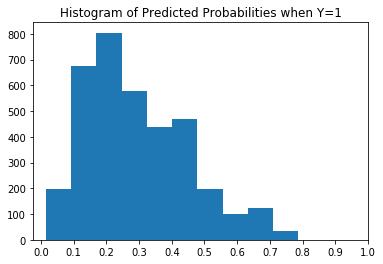

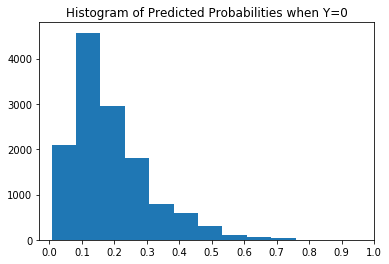

In [108]:
# Plot Histograms of Predicted Probabilities when Y=1 and Y=1 using validation set
Y_and_Y_hat = f.actual_and_predicted_values(logit_base, valid, False, \
              ['Y', 'Median_household_income'])
f.predicted_proba_histograms_by_Y(Y_and_Y_hat)

### 1.2 Unregularized logit. Comment on model performance:

**Using training data:**

The **log-loss** of unregularized logit is **0.458** (adjusted for N).  The log-loss on validation set is very close, at **0.467**. 

**Using validation data:**

**AUC** is 0.713148.

When we set the **decision threshold at 0.5**, the **false positive rate, or Pr(Type I error), or Pr(predict relief when none)** is relatively low at 0.021. But the false negative rate is quite high:

**False negative rate, or Pr(Type II error), or Pr(predict no \$ when compensation granted)** is 0.898. 

In short, the estimated unregularized logit model favors the negative, majority class. It fails to predict a positive label in the majority of cases with actual monetary relief with the given decision threshold. 

If we **lower the decision threshold to 0.2**, the false negative rate drops to 0.327 - that is, we are able to identify roughly 67\% of all complaints with monetary relief correctly. However, we also end up with a lot of false positives - complaints that we label as settled with monetary compensation when, in reality, they were not (FPR = 0.366). 

Now take a look at **histograms:** 

- When I examine estimated probabilities for actual Y=0, the patterns looks good, meaning that the majority of predicted probabilities are less than 0.5 and are classified as Y-hat = 0. 
- For Y=1, again the bulk of estimated probabilities tend to lie **below** the 0.5 threshold, which leads to incorrect predictions of Y-hat=0. 
- **One solution** could be to lower the decision threshold from 0.5 to something smaller. This would lower the Pr(Type II error), but increase Pr(Type I error). The problem, however, is that with the current set of predictions, for us to minimize Pr(Type II error), the revised threshold would have to tend to zero, which would inflate Pr(Type I error) close to 1. The model will essentially continue being subpar.
- So, **ideally**, we want to improve our model so that the first histogram would be skewed more to the right instead of the left - i.e., give higher probability estimates when Y=1 for the data points that are currently ranked below the decision threshold of 0.5.  


Below I continue experimenting with various model enhancements to see if I can impprove its predictive power.

### 1.3 Comment on feature pre-processing 

Note that I log-transformed one of the ACS (Census) variables above: median household income. Log-transformation 'squeezes' the distribution of an otherwise skewed variable, susceptible to the influence of outliers. And, unlike in decision trees, outliers can really distort coefficient estimates in OLS and logit regression models.

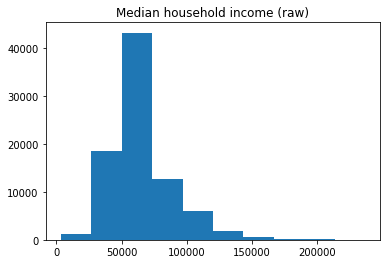

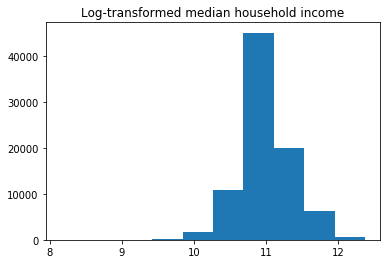

In [32]:
# Plot histograms of median household income and its log transformed version

# Median Household Income
plt.hist(df['Median_household_income'])
plt.title('Median household income (raw)')
plt.show()

# Ln(Median Household Income)
plt.hist(df['ln_median_income'])
plt.title('Log-transformed median household income')
plt.show()



The purpose of feature pre-processing is to ensure that the scale of variables included in the regression model is more or less the same. This helps minimize the risk of scenarios where estimation is dominated by a few large features. More on this here: https://scikit-learn.org/stable/modules/preprocessing.html. 


Below, I only pre-process ACS (Census) variables and do not demean and rescale dummy variables. First, dummy variables are already constrained to be either 0 or 1. Second, I also care about the interpretation of estimated coefficients on dummies, though this is not the regular practice or objective in a lot of machine learning projects. 

Moreover, as we will see below, preprocessing does not really change the fundamental results for as long as I do not use any higher-order polynomials. It changes coefficient estimates on the preprocessed variables and the constant term but does not affect the coefficients of unscaled dummy variables, predicted probabilities, and AUC. In addition, the logit results reported above show that coefficient estimates on un-preprocessed ACS variables are small and mostly statistically insignificant what assuages any possible concerns regarding misleading, scale-driven influence of continuous raw ACS variables relative to dummies.


In [33]:
# Define ACS variables
ACS_vars = ['unemployment_rate', 'Commutes_to_work_drives_alone',
       'Mean_travel_time', 'Median_household_income', 'percent_with_earnings',
       'percent_civil_pop_without_health_ins',
       'percent_below_poverty_families', 'median_age', 'age_0_19',
       'age_65_plus', 'ln_median_income']

In [34]:
# Summary of ACS variables
df[ACS_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
unemployment_rate,"84,575.000",7.942,3.344,0.000,6.000,7.942,8.600,100.000
Commutes_to_work_drives_alone,"84,575.000",73.483,15.188,0.000,73.483,75.400,81.900,100.000
Mean_travel_time,"84,575.000",27.106,5.528,6.300,23.700,27.106,29.400,113.500
Median_household_income,"84,575.000","66,571.234","23,730.800","3,479.000","51,079.000","66,571.234","73,856.000","236,500.000"
percent_with_earnings,"84,575.000",79.200,7.387,0.000,77.300,79.200,83.200,100.000
percent_civil_pop_without_health_ins,"84,575.000",11.434,5.738,0.000,7.700,11.434,13.100,100.000
percent_below_poverty_families,"84,575.000",9.948,6.824,0.000,5.300,9.948,11.100,100.000
median_age,"84,575.000",38.949,5.493,15.500,36.000,38.949,41.100,91.800
age_0_19,"84,575.000",24.591,5.047,0.000,23.000,24.591,26.900,91.900
age_65_plus,"84,575.000",14.565,5.721,0.000,11.600,14.565,15.800,100.100


In [35]:
# Calculate the scaler = means and standard deviations of ACS var in train data
scaler = preprocessing.StandardScaler().fit(train[ACS_vars])

#scaler.mean_     #estimated means
#scaler.scale_   #estimated standard deviations

#Preprocess train, valid, and test data:
train_census_preprocessed = train.copy()
valid_census_preprocessed = valid.copy()
test_census_preprocessed = test.copy()

for i, var in enumerate(ACS_vars):

    train_census_preprocessed[var] =\
        (train_census_preprocessed[var] - scaler.mean_[i])/scaler.scale_[i]  
    valid_census_preprocessed[var] = \ 
        (valid_census_preprocessed[var] - scaler.mean_[i])/scaler.scale_[i]  
    test_census_preprocessed[var] = \
        (test_census_preprocessed[var] - scaler.mean_[i])/scaler.scale_[i]  


### 2. Unregularized logistic regression using preprocessed ACS variables 

In [36]:
# Fit the logistic regression to preprocessed train data
logit_preprocess_unr = sm.Logit(train_census_preprocessed['Y'], train_census_preprocessed.drop(['Y', 'Median_household_income'], axis=1))
logit_preprocess_unr = logit_preprocess_unr.fit()


Optimization terminated successfully.
         Current function value: 0.458000
         Iterations 8


In [37]:
# Calculate AUC (on valid) and log-loss (on train & valid) for fitted unregularized logit with preprocessed ACS data
auc_and_logloss_results =\
    f.store_AUC_and_logloss_results(logit_preprocess_unr, 'base_2_preprocess', False, \
    train_census_preprocessed, valid_census_preprocessed, ['Y', 'Median_household_income'],auc_and_logloss_results)
auc_and_logloss_results

{'base_no_preprocess': {'AUC': '0.713148',
  'logloss_train': '0.458000',
  'logloss_valid': '0.467460'},
 'base_2_preprocess': {'AUC': '0.713148',
  'logloss_train': '0.458000',
  'logloss_valid': '0.467460'}}

In [38]:
# Calculate % of false positives and false negatives on the unregularized logit with pre-processed ACS vars
fpr_and_fnr_results = {}
fpr_and_fnr_results = \
    f.store_fpr_and_fnr_results(logit_preprocess_unr, \
    'base_2_preprocess, threshold of {}'.format(0.5), False, \
    valid_census_preprocessed, ['Y', 'Median_household_income'], 0.5, fpr_and_fnr_results)
fpr_and_fnr_results

{'base_2_preprocess, threshold of 0.5': {'fpr': '0.021', 'fnr': '0.898'}}

Note that in my model, preprocessing affects the estimated coefficients on the ACS (preprocessed) variables and the constant term only. Other coefficients and AUC remain the same. How pre-processing is 'un-done' in this particular case is shown below:


- **Original equation (un-preprocessed train data):** 

\begin{equation*}  
y = a+bX + cZ 
\end{equation*}

- **Preprocess X (an ACS variable) and leave dummy Z "as is"**

\begin{equation}  
\hat{X} = \frac{X - \mu}{\sigma} 
\end{equation}

- **Updated equation (preprocessed train data):**

\begin{equation}  
y = \alpha+\beta \hat{X} + \gamma Z  =  \alpha+\beta (\frac{X - \mu}{\sigma}) + \gamma Z = 
(\alpha - \beta \frac{\mu}{\sigma}) +\frac{\beta}{\sigma} X + \gamma Z
\end{equation}


- **Hence, the relationship between unpreprocessed and preprocessed coefficients is as follows:**

\begin{equation}  
a = \alpha - \beta \frac{\mu}{\sigma}
\end{equation}


\begin{equation}  
b = \frac{\mu}{\sigma}
\end{equation}


\begin{equation}  
c = \gamma
\end{equation}

In regressions below I continue using preprocessed train data for consistency.

### 3. L2 (Ridge) Regularized logistic regression using preprocessed ACS variables

Now I introduce Ridge regularization to see if model performance can be improved on the validation set as measured by AUC.

In [39]:
# L2 regularized logit for several hyperparameter values
for i in range(6,-7, -1):
    logreg = LogisticRegression(C=10**i, fit_intercept = False, solver='liblinear')
    logreg = logreg.fit(train_census_preprocessed.drop(['Y', 'Median_household_income'], axis=1), 
               train_census_preprocessed['Y'])
    
    # Calculate AUC (on valid) and log-loss (on train & valid) 
    auc_and_logloss_results = \
        f.store_AUC_and_logloss_results(logreg, \
        'L2 C={} {}'.format(10**i, (7-len(str(10**i)))*" "), True, \
        train_census_preprocessed, valid_census_preprocessed, \
        ['Y', 'Median_household_income'],auc_and_logloss_results)
    

In [41]:
view_results = pd.DataFrame(auc_and_logloss_results).T
view_results

,AUC,logloss_train,logloss_valid
base_no_preprocess,0.713148,0.458000,0.467460
base_2_preprocess,0.713148,0.458000,0.467460
L2 C=1000000,0.713147,0.458000,0.467460
L2 C=100000,0.713146,0.458000,0.467461
L2 C=10000,0.713147,0.458000,0.467460
L2 C=1000,0.713146,0.458000,0.467461
L2 C=100,0.713145,0.458000,0.467462
L2 C=10,0.713140,0.458000,0.467462
L2 C=1,0.713050,0.458005,0.467482
L2 C=0.1,0.712078,0.458313,0.467867


In [42]:
# Print the model that gives the highest AUC
view_results[view_results.AUC == view_results.AUC.max()]

,AUC,logloss_train,logloss_valid
base_no_preprocess,0.713148,0.458000,0.467460
base_2_preprocess,0.713148,0.458000,0.467460


**Results of introducing regularization:**

Despite trying several Ridge regularization hyperparameters, it is the baseline model that gives the highest AUC on the validation set. Below, I repeat the same exercise with L1 penalty function and obtain similar results. In short, it looks like regularization is not helping us with making the model developed on the train set more generalizable. **It could be that the original, unregularized model is already simple enough, overfitting is not a major concern, and hence regularization mostly just adds some noise without improving model performance.**

**Remember that the baseline model was trained on an already transformed dataset where I tried to minimize the influence of noise by groupping smaller categories together (e.g., went from 33 Issue categories to only 19, from 400+ companies to 11, etc.).**

In addition, it could be that there is not sufficient information in the data to understand how to separate classes into Y=1 and Y=0, and the original unregularized regression would be simple enough capturing only basic patterns in data, as suggested by the histograms of estimated probabilities for Y=1 vs Y=0 above.

### 4. L1 (Lasso) Regularized logistic regression using preprocessed ACS variables

In [43]:
# L1 regularized logit for several hyperparameter values
for i in range(6,-7, -1):
    logreg = LogisticRegression(penalty='l1', C=10**i, fit_intercept = False, solver='liblinear')
    logreg.fit(train_census_preprocessed.drop(['Y', 'Median_household_income'], axis=1), train_census_preprocessed['Y'])
   
    # Calculate AUC (on valid) and log-loss (on train & valid) 
    auc_and_logloss_results = \
        f.store_AUC_and_logloss_results(logreg, \
            'L1 C0={} {}'.format(10**i, (7-len(str(10**i)))*" "), True, \
            train_census_preprocessed, valid_census_preprocessed, \
            ['Y', 'Median_household_income'],auc_and_logloss_results)

In [44]:
view_results = pd.DataFrame(auc_and_logloss_results).T
view_results

,AUC,logloss_train,logloss_valid
base_no_preprocess,0.713148,0.458000,0.467460
base_2_preprocess,0.713148,0.458000,0.467460
L2 C=1000000,0.713147,0.458000,0.467460
L2 C=100000,0.713146,0.458000,0.467461
L2 C=10000,0.713147,0.458000,0.467460
L2 C=1000,0.713146,0.458000,0.467461
L2 C=100,0.713145,0.458000,0.467462
L2 C=10,0.713140,0.458000,0.467462
L2 C=1,0.713050,0.458005,0.467482
L2 C=0.1,0.712078,0.458313,0.467867


In [45]:
# Print the model that gives the highest AUC
view_results[view_results.AUC == view_results.AUC.max()]

,AUC,logloss_train,logloss_valid
base_no_preprocess,0.713148,0.458000,0.467460
base_2_preprocess,0.713148,0.458000,0.467460


## 5. Adding complexity: Retain the richness of categorical variables in the CFBP set

Next, I want to see if my baseline model can be improved upon if I use the original set of categories/labels in the CFPB variables (e.g., the original set of all 33 Issue categories, 400+ companies, etc.). So, I go back to the downloaded CFPB data, skip the recoding step, and keep all original categories instead. I continue excluding the baseline categories. I also keep the Timely response variable and year 2011 observations that I previously dropped. I end up with a much larger set of dummy variables from the original set of CFPB features (N=555 vs N=76).

**Aside note:** If I use statsmodels.api to train an unregularized (or any) logit model, I run into the problem that I initially mentioned in the IPython Notebook #1. Some dummy variables are too sparse: they contain only a few values of 1. This causes problems during estimation as the variance-covariance matrix becomes singular (non-invertible). 
In sklearn's logistic regression package, I probably do not run into this problem because of the way the objective function is defined there: it always comes with a penalty term. To mimic the unregularized regression using sklearn, we need to set a very high value for parameter C (e.g., 1e30). 

When I tried using statsmodels.api, after a few trials and errors, I was able to run a logistic regression by dropping dummies with fewer than 300 values of 1. Number of features is 131 vs 76 in the original set of models above. The results are very similar to the ones obtained below with sklearn and are not reported here.



In [7]:
# Load the original CFPB data
df_expanded =pd.read_csv(directory+'Consumer_Complaints_loaded_March20_2017.csv', header = 0, sep = ',', dtype = 'str')
print('Size of original file: ', df_expanded.shape)
print()

# This function creates dummies and adds a constant term
df_expanded = p.create_dummies_fn(df_expanded)

# Load the ACS (Census) data
socio_econ_data = pd.read_pickle(open(directory+'ACS_census_data.pickle', 'rb'))

# This function adds ACS (Census) variables
df_expanded = p.add_ACS_data_fn(df_expanded, socio_econ_data, ['ZIP code']+ACS_vars)

# This function drops original CFPB variables (e.g., 'Issue', 'ZIP code', 'Company', etc.)
df_expanded = p.drop_columns_for_logit(df_expanded)

print('Size of transformed file:', df_expanded.shape)


Size of original file:  (738832, 18)

--- # of categories in variable 'Issue':  33

--- 'Consumer complaint narrative' is either NUll or contains text of a complaint 

--- # of companies:  418

--- # of U.S. states and territories:  62

--- # of Tags:  3

--- # of categories in 'Consumer consent provided?':  3

--- # of Submission categories:  6

--- Binary variable 'Timely_response'

--- Varibale Year

--- Variable Month

--- Add constant term

Done creating dummy variables
______________________________________
Done adding ACS (Census data)
______________________________________
Done dropping redundant columns
______________________________________
Size of transformed file: (85835, 555)


**df_expanded** contains the original categories of dummy variables, a constant term, and un-preprocessed ACS data. The number of rows in df_expanded (n=85,835) differs from the number of rows in df (n=84,575) due to the additional year 2011 observations.


### 5.1 More complete data: Unregularized logistic regression using preprocessed ACS variables 

In [10]:
#Create train, validation, and test sets 
train_expanded = df_expanded.sample(frac=0.6,replace = False, random_state=200)
temp_expanded = df_expanded.drop(train_expanded.index)
valid_expanded = temp_expanded.sample(frac=0.5,replace = False, random_state=100)
test_expanded = temp_expanded.drop(valid_expanded.index)
print("Size of expanded train, valid, and test files: ", train_expanded.shape, \
      valid_expanded.shape, test_expanded.shape)
print()   

# Calculate the scaler = means and standard deviations of ACS var in train expanded data
scaler_expanded = preprocessing.StandardScaler().fit(train_expanded[ACS_vars])

#Preprocess train, valid, and test data:
train_expanded_preprocessed = train_expanded.copy()
valid_expanded_preprocessed = valid_expanded.copy()
test_expanded_preprocessed = test_expanded.copy()

for i, var in enumerate(ACS_vars):

    train_expanded_preprocessed[var] =\
    (train_expanded_preprocessed[var] - scaler_expanded.mean_[i])/scaler_expanded.scale_[i]  
    
    valid_expanded_preprocessed[var] =\
    (valid_expanded_preprocessed[var] - scaler_expanded.mean_[i])/scaler_expanded.scale_[i]  
    
    test_expanded_preprocessed[var] =\
    (test_expanded_preprocessed[var] - scaler_expanded.mean_[i])/scaler_expanded.scale_[i]  


Size of expanded train, valid, and test files:  (51501, 555) (17167, 555) (17167, 555)



In [46]:
# Fit unregularized logistic regression to preprocessed expanded train data using sklearn's package
logit_expanded_unr = LogisticRegression(C=1e30, fit_intercept = False, solver='liblinear')
logit_expanded_unr.fit(train_expanded_preprocessed.drop(['Y', 'Median_household_income'], axis=1), \
                       train_expanded_preprocessed['Y'])

#initiate new dictionary for auc & log-loss values (for expanded dataset)
auc_logloss_expanded_results = {}
#store the original baseline auc & log-loss (the best performer on the df set)
auc_logloss_expanded_results['base_no_preprocess'] = auc_and_logloss_results['base_no_preprocess'] 

# Calculate AUC (on valid) and log-loss (on train & valid)
auc_logloss_expanded_results = \
        f.store_AUC_and_logloss_results(logit_expanded_unr, \
        'base_expanded_unr_preprocessed', True, \
        train_expanded_preprocessed, valid_expanded_preprocessed, \
        ['Y', 'Median_household_income'],auc_logloss_expanded_results)    

In [47]:
# Calculate % of false positives and false negatives on the unregularized logit on the expanded set
fpr_and_fnr_results =\
        f.store_fpr_and_fnr_results(logit_expanded_unr, \
         'base_expanded_unr_preprocessed', True,
        valid_expanded_preprocessed, ['Y', 'Median_household_income'], 0.5, fpr_and_fnr_results)
fpr_and_fnr_results

{'base_2_preprocess, threshold of 0.5': {'fpr': '0.021', 'fnr': '0.898'},
 'base_expanded_unr_preprocessed': {'fpr': '0.026', 'fnr': '0.876'}}

In [48]:
# L2 regularized logit for several hyperparameter values on expanded, preprocessed data
for i in range(6,-7, -1):
    logreg = LogisticRegression(C=10**i, fit_intercept = False, solver='liblinear')
    logreg.fit(train_expanded_preprocessed.drop(['Y', 'Median_household_income'], axis=1), \
               train_expanded_preprocessed['Y'])
    
    # Calculate AUC (on valid) and log-loss (on train & valid) 
    auc_logloss_expanded_results = \
        f.store_AUC_and_logloss_results(logreg, \
        'L2 C={} {}'.format(10**i, (7-len(str(10**i)))*" "), True, \
        train_expanded_preprocessed, valid_expanded_preprocessed, \
        ['Y', 'Median_household_income'],  auc_logloss_expanded_results)
 

In [49]:
view_results_expanded = pd.DataFrame(auc_logloss_expanded_results).T
view_results_expanded

,AUC,logloss_train,logloss_valid
base_no_preprocess,0.713148,0.458000,0.467460
base_expanded_unr_preprocessed,0.740367,0.444814,0.451924
L2 C=1000000,0.740382,0.444820,0.451817
L2 C=100000,0.740367,0.444815,0.451908
L2 C=10000,0.740378,0.444821,0.451801
L2 C=1000,0.740396,0.444833,0.451667
L2 C=100,0.740464,0.444916,0.451376
L2 C=10,0.740462,0.445266,0.451179
L2 C=1,0.740409,0.446108,0.451118
L2 C=0.1,0.738987,0.448293,0.452567


In [50]:
# Print the model that gives the highest AUC
view_results_expanded[view_results_expanded.AUC == view_results_expanded.AUC.max()]

,AUC,logloss_train,logloss_valid
L2 C=100,0.740464,0.444916,0.451376


In [51]:
# L1 regularized logit for several hyperparameter values on expanded, preprocessed data
for i in range(6,-7, -1):
    logreg = LogisticRegression(penalty='l1', C=10**i, fit_intercept = False, solver='liblinear')
    logreg.fit(train_expanded_preprocessed.drop(['Y', 'Median_household_income'], axis=1), \
               train_expanded_preprocessed['Y'])
    
    # Calculate AUC (on valid) and log-loss (on train & valid) 
    auc_logloss_expanded_results = \
        f.store_AUC_and_logloss_results(logreg, \
        'L1 C0={} {}'.format(10**i, (7-len(str(10**i)))*" "), True, \
        train_expanded_preprocessed, valid_expanded_preprocessed, \
        ['Y', 'Median_household_income'],  auc_logloss_expanded_results)
 

In [52]:
view_results_expanded = pd.DataFrame(auc_logloss_expanded_results).T
view_results_expanded

,AUC,logloss_train,logloss_valid
base_no_preprocess,0.713148,0.458000,0.467460
base_expanded_unr_preprocessed,0.740367,0.444814,0.451924
L2 C=1000000,0.740382,0.444820,0.451817
L2 C=100000,0.740367,0.444815,0.451908
L2 C=10000,0.740378,0.444821,0.451801
L2 C=1000,0.740396,0.444833,0.451667
L2 C=100,0.740464,0.444916,0.451376
L2 C=10,0.740462,0.445266,0.451179
L2 C=1,0.740409,0.446108,0.451118
L2 C=0.1,0.738987,0.448293,0.452567


In [53]:
# Print the model that gives the highest AUC
view_results_expanded[view_results_expanded.AUC == view_results_expanded.AUC.max()]

,AUC,logloss_train,logloss_valid
L1 C0=100,0.740481,0.444853,0.451581


In [54]:
# Calculate % of false positives and false negatives for L1 with C=100 on the expanded dataset
logreg_L1_C100 = LogisticRegression(penalty='l1', C=100, fit_intercept = False, solver='liblinear')
logreg_L1_C100.fit(train_expanded_preprocessed.drop(['Y', 'Median_household_income'], axis=1), \
               train_expanded_preprocessed['Y'])

fpr_and_fnr_results = \
    f.store_fpr_and_fnr_results(logreg_L1_C100, \
    'L1_C100_expanded_preprocessed', True, \
    valid_expanded_preprocessed, ['Y', 'Median_household_income'], 0.5, fpr_and_fnr_results)
fpr_and_fnr_results

{'base_2_preprocess, threshold of 0.5': {'fpr': '0.021', 'fnr': '0.898'},
 'base_expanded_unr_preprocessed': {'fpr': '0.026', 'fnr': '0.876'},
 'L1_C100_expanded_preprocessed': {'fpr': '0.026', 'fnr': '0.876'}}

**Results of using all available categories/labels in categorical variables:**

Overall, using a complete set of labels in categorical variables makes models more nuanced, increases AUC, and lowers log-loss (at least for as long as regularization is not too strong). The best performer (as measured by AUC) on the expanded dataset is L1 regularized model with hyperparamer C=100.

- AUC on original dataset with groupped categories (unregularized, best perfomer on dataset with groupped categories): 0.713148
- AUC on expanded dataset (unregularized): 0.740367
- AUC on expanded dataset (best performer on expanded dataset, L1 with C=100): 0.74048


- Log-loss on original dataset with groupped categories (unregularized, best perfomer on dataset with groupped categories): 0.458000 (on train)
- Log-loss on expanded dataset (unregularized): 0.444814
- Log-loss on expanded dataset (best performer on expanded dataset, L1 with C=100): 0.444853


- **Additional, smaller categories that made it into the model this time added some valuable information as even the unregularized model's (most prone to overfitting due to noise) AUC went up from 0.7131 to 0.7404 and log-loss slightly declined.** 
- **However, these effects seem small, and the value-added to the predictive power of our model is very marginal. Note that FNR or Pr(Type II error)=87.6% is still pretty high on the expanded set that uses all categories and regularization (went down by only 2 percentage points for the decision threshold of 0.5!).** 
- **Noise and overfitting do not seem to be a big issue as the unregularized model performs very similarly to the best perfomer L1 with C=100 (on the expanded set). In addition, log-loss on train and validation datasets are very close, what indicates that the models are neither overfit nor underfit.** 



## 6. Balanced outcome

One other issue that I explore is the unbalanced nature of the outcome variable. Even though the case here is not as extreme as 1:99, for example, the ratio of positive to negative outcomes is roughly 20:80, i.e., still quite unbalanced. This means that the model favors predicting the negative outcome, and we have very high Pr(Type II error). One could perform downsampling or upsampling to arrive at a more balanced distribution of labels in the outcome. I choose a simpler, more practical way to examine this issue by utilizing 'class_weight' option in the sklearn's logistic regression package.

In [8]:
print('% of negative and positive outcomes: ')
df_expanded.Y.value_counts()/df_expanded.shape[0]

% of negative and positive outcomes: 


0    0.792637
1    0.207363
Name: Y, dtype: float64

In [15]:
# L2 regularized logit with balanced class weight for several hyperparameter values on expanded, preprocessed data
auc_logloss_balanced_results = {}
for i in range(6,-7, -1):
    logreg = LogisticRegression(C=10**i, fit_intercept = False, class_weight='balanced', \
            solver='liblinear')
    logreg.fit(train_expanded_preprocessed.drop(['Y', 'Median_household_income'], axis=1), \
            train_expanded_preprocessed['Y'])
    
    # Calculate AUC (on valid) and log-loss (on train & valid) 
    auc_logloss_balanced_results = \
        f.store_AUC_and_logloss_results(logreg, \
        'L2 C={} {}'.format(10**i, (7-len(str(10**i)))*" "), True, \
        train_expanded_preprocessed, valid_expanded_preprocessed, \
        ['Y', 'Median_household_income'],  auc_logloss_balanced_results)
 

In [16]:
# L1 regularized logit with balanced class weight for several hyperparameter values on expanded, preprocessed data
for i in range(6,-7, -1):
    logreg = LogisticRegression(penalty='l1',C=10**i, fit_intercept=False, \
                                class_weight='balanced', solver='liblinear' )
    logreg.fit(train_expanded_preprocessed.drop(['Y', 'Median_household_income'], axis=1), \
               train_expanded_preprocessed['Y'])
    
    # Calculate AUC (on valid) and log-loss (on train & valid) 
    auc_logloss_balanced_results = \
        f.store_AUC_and_logloss_results(logreg, \
        'L1 C0={} {}'.format(10**i, (7-len(str(10**i)))*" "), True, \
        train_expanded_preprocessed, valid_expanded_preprocessed, \
        ['Y', 'Median_household_income'],  auc_logloss_balanced_results)


In [55]:
# Print the model that gives the highest AUC
view_results_balanced = pd.DataFrame(auc_logloss_balanced_results).T
view_results_balanced[view_results_balanced.AUC == view_results_balanced.AUC.max()]

,AUC,logloss_train,logloss_valid
L2 C=1,0.740580,0.599034,0.599486


In [56]:
# Calculate % of false positives and false negatives for L2 with C=1 on the 
# expanded dataset with balanced weights
logreg_L2_C1 = LogisticRegression(penalty='l2', C=1, fit_intercept = False, \
                                  class_weight='balanced', solver='liblinear')
logreg_L2_C1.fit(train_expanded_preprocessed.drop(['Y', 'Median_household_income'], axis=1), \
               train_expanded_preprocessed['Y'])
    
fpr_and_fnr_results = \
    f.store_fpr_and_fnr_results(logreg_L2_C1, \
    'L2_C1_expanded_balanced_w', True, \
    valid_expanded_preprocessed, ['Y', 'Median_household_income'], 0.5, fpr_and_fnr_results)
fpr_and_fnr_results

{'base_2_preprocess, threshold of 0.5': {'fpr': '0.021', 'fnr': '0.898'},
 'base_expanded_unr_preprocessed': {'fpr': '0.026', 'fnr': '0.876'},
 'L1_C100_expanded_preprocessed': {'fpr': '0.026', 'fnr': '0.876'},
 'L2_C1_expanded_balanced_w': {'fpr': '0.340', 'fnr': '0.317'}}

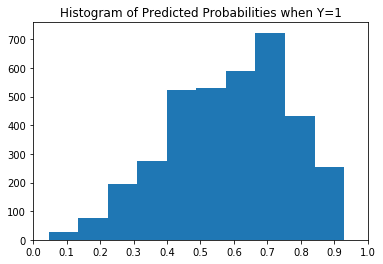

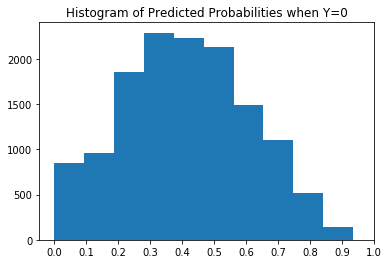

In [118]:
# Plot Histograms of Predicted Probabilities when Y=1 and Y=1 using validation set
Y_and_Y_hat_balanced = f.actual_and_predicted_values(logreg_L2_C1, \
                        valid_expanded_preprocessed, True, \
                        ['Y', 'Median_household_income'])
f.predicted_proba_histograms_by_Y(Y_and_Y_hat_balanced)

In [119]:
# Calculate % of false positives and false negatives on the 'balanced weights best performer'
fpr_and_fnr_results_balanced = {}
for i in  [i/100 for i in range(60,15,-5)]:
    fpr_and_fnr_results_balanced = \
    f.store_fpr_and_fnr_results(logreg_L2_C1, \
    'Balanced weights, threshold of {}'.format(i), True, valid_expanded_preprocessed, \
    ['Y', 'Median_household_income'], i, fpr_and_fnr_results_balanced)
fpr_and_fnr_results_balanced

{'Balanced weights, threshold of 0.6': {'fpr': '0.186', 'fnr': '0.498'},
 'Balanced weights, threshold of 0.55': {'fpr': '0.257', 'fnr': '0.400'},
 'Balanced weights, threshold of 0.5': {'fpr': '0.340', 'fnr': '0.317'},
 'Balanced weights, threshold of 0.45': {'fpr': '0.428', 'fnr': '0.228'},
 'Balanced weights, threshold of 0.4': {'fpr': '0.517', 'fnr': '0.158'},
 'Balanced weights, threshold of 0.35': {'fpr': '0.604', 'fnr': '0.107'},
 'Balanced weights, threshold of 0.3': {'fpr': '0.696', 'fnr': '0.074'},
 'Balanced weights, threshold of 0.25': {'fpr': '0.784', 'fnr': '0.041'},
 'Balanced weights, threshold of 0.2': {'fpr': '0.853', 'fnr': '0.018'}}

In [120]:
# Print baseline fpr and fnr results from above
fpr_and_fnr_results_base

{'base_no_preprocess, threshold of 0.6': {'fpr': '0.008', 'fnr': '0.943'},
 'base_no_preprocess, threshold of 0.55': {'fpr': '0.012', 'fnr': '0.927'},
 'base_no_preprocess, threshold of 0.5': {'fpr': '0.021', 'fnr': '0.898'},
 'base_no_preprocess, threshold of 0.45': {'fpr': '0.041', 'fnr': '0.836'},
 'base_no_preprocess, threshold of 0.4': {'fpr': '0.070', 'fnr': '0.743'},
 'base_no_preprocess, threshold of 0.35': {'fpr': '0.103', 'fnr': '0.661'},
 'base_no_preprocess, threshold of 0.3': {'fpr': '0.150', 'fnr': '0.590'},
 'base_no_preprocess, threshold of 0.25': {'fpr': '0.237', 'fnr': '0.473'},
 'base_no_preprocess, threshold of 0.2': {'fpr': '0.366', 'fnr': '0.327'}}

In [ ]:
AUC on expanded dataset (unregularized): 0.740367
AUC on expanded dataset (best performer on expanded dataset, L1 with C=100): 0.74048

**Results of using balanced weights:**

- With balanced class weights, the L2 model with hyperparameter C=1 gives the highest AUC of 0.740580. This is a relatively minor improvement upon the L1 regularized model with C=100 and "as is" unbalanced class weights, where AUC is 0.74048. 


- The best performer with balanced weights has a much higher training-set log-loss of 0.599034. It is even higher than the training-set log-loss in the first, unregularized model on the dataset with groupped categories (0.458000). This is likely due to the higher weights on the minority class added to the loss function.


- Histograms of predicted probabilities with balanced weights reveal a more desirable right-side skewness when Y=1 => a lower false negative rate at the majority of threshold values as more true positives are now correctly classified as positives.


- However, for Y=0 the histogram of predicted probabilities is now more centered rather than left-skewed as before => more true negatives are now also identified as positives => higher false positive rate. 


- So, what do balanced weights achieve? A slightly higher AUC and a stronger bias towards the positive class than before but with a trade-off: the model is now predicting more positive outcomes, and we have a lower false negative rate (when Y=1) but a higher false positive rate (when Y=0). The model starts favoring the majority (negative) class less and starts predicting more of positive outcomes. As a result, for the given decision threshold of 0.5, the FNR falls from 0.898 to 0.317 (because we have more predicted positive labels now) but FPR increases from 0.021 to 0.340. Note that in an unbalanced model, we achieve a similar (FPR, FNR) = (0.366, 0.327) trade-off with a decision threshold of 0.2 that gives us more positive predictions than the decision threshold of 0.5.


Next, instead of using zip code-level information captured in ACS (Census) prerocessed variables, I use zip code dummies instead. Remember that zip code dummies capture more or less permanent differences across zip codes (e.g., size, zip code's "typical" socio-economic ranking relative to other zip codes, etc.). 

Note that there are over 15,000 zip codes in the CFPB dataset. Some of the zip codes have been partially masked (e.g., the last two digits were replaced by 'XX'). So, I take 3-digit zip codes instead of 5-digit ones and include their dummies in the regression. The hope is that more granular geographic information could potentially give additional levers to correctly separate positive and negative outcomes. 

Because the model with balanced weights gave me the highest AUC so far, all models with zip codes will be trained with balanced weights as well.


## 7. Including Zip Codes

In [123]:
# Load the original CFPB data
df_zip =pd.read_csv(directory+'Consumer_Complaints_loaded_March20_2017.csv', header = 0, sep = ',', dtype = 'str')

# This function creates non-zip code dummies and adds a constant term
df_zip = p.create_dummies_fn(df_zip)

# This function creates zip code dummies
df_zip = p.zip_code_dummies(df_zip)

# This function drops original CFPB variables (e.g., 'Issue', 'ZIP code', 'Company', etc.)
df_zip= p.drop_columns_for_logit(df_zip)

print('Size of transformed file with zip code dummies:', df_zip.shape)


--- # of categories in variable 'Issue':  33

--- 'Consumer complaint narrative' is either NUll or contains text of a complaint 

--- # of companies:  418

--- # of U.S. states and territories:  62

--- # of Tags:  3

--- # of categories in 'Consumer consent provided?':  3

--- # of Submission categories:  6

--- Binary variable 'Timely_response'

--- Varibale Year

--- Variable Month

--- Add constant term

Done creating dummy variables
______________________________________
# of 3-digit zip codes:  939

Done creating 3-digit ZIP code dummies
______________________________________
Done dropping redundant columns
______________________________________
Size of transformed file with zip code dummies: (85835, 1482)


In [124]:
#Create train, validation, and test sets 
train_zip = df_zip.sample(frac=0.6,replace = False, random_state=200)
temp_zip = df_zip.drop(train_zip.index)
valid_zip = temp_zip.sample(frac=0.5,replace = False, random_state=100)
test_zip = temp_zip.drop(valid_zip.index)
print("Size of zip train, valid, and test files: ", train_zip.shape, \
      valid_zip.shape, test_zip.shape)
print()   

# No preprocessing is necessary as all features are dummy variables

Size of zip train, valid, and test files:  (51501, 1482) (17167, 1482) (17167, 1482)



In [142]:
auc_logloss_zip_results = {}
# L2 regularized logit for several hyperparameter values on expanded data with 
# 3-digit zip code dummies
for i in range(6,-7, -1):
    logreg = LogisticRegression(C=10**i, fit_intercept = False, \
             class_weight='balanced', solver='liblinear')
    logreg.fit(train_zip.drop(['Y'], axis=1), train_zip['Y'])
    
    # Calculate AUC (on valid) and log-loss (on train & valid) 
    auc_logloss_zip_results = \
        f.store_AUC_and_logloss_results(logreg, \
        'L2 C={} {}'.format(10**i, (7-len(str(10**i)))*" "), True, \
        train_zip, valid_zip, ['Y'],  auc_logloss_zip_results)


In [144]:
# L1 regularized logit with balanced class weight for several hyperparameter values on expanded data 
# with 3-digit zip code dummies
for i in range(6,-7, -1):
    logreg = LogisticRegression(penalty='l1',C=10**i, fit_intercept = False, \
             class_weight='balanced', solver='liblinear')
    logreg.fit(train_zip.drop(['Y'], axis=1), train_zip['Y'])
    
    # Calculate AUC (on valid) and log-loss (on train & valid) 
    auc_logloss_zip_results = \
        f.store_AUC_and_logloss_results(logreg, \
        'L1 C0={} {}'.format(10**i, (7-len(str(10**i)))*" "), True, \
        train_zip, valid_zip, ['Y'],  auc_logloss_zip_results)

In [145]:
# Print the model that gives the highest AUC
view_results_zip = pd.DataFrame(auc_logloss_zip_results).T
view_results_zip[view_results_zip.AUC == view_results_zip.AUC.max()]

,AUC,logloss_train,logloss_valid
L1 C0=0.1,0.740039,0.602398,0.600703


In [148]:
# Calculate % of false positives and false negatives for L1 with C=0.1 on 
# the dataset with 3-digit zip codes
logreg_L1_C01 = LogisticRegression(penalty='l1', C=0.1, fit_intercept = False, \
                class_weight='balanced', solver='liblinear')
logreg_L1_C01.fit(train_zip.drop(['Y'], axis=1), train_zip['Y'])
    
fpr_and_fnr_results = \
    f.store_fpr_and_fnr_results(logreg_L1_C01, 'L1_C01_zip_balanced_w', True, \
    valid_zip, ['Y'], 0.5, fpr_and_fnr_results)
fpr_and_fnr_results


{'base_2_preprocess, threshold of 0.5': {'fpr': '0.021', 'fnr': '0.898'},
 'base_expanded_unr_preprocessed': {'fpr': '0.026', 'fnr': '0.876'},
 'L1_C100_expanded_preprocessed': {'fpr': '0.026', 'fnr': '0.876'},
 'L2_C1_expanded_balanced_w': {'fpr': '0.340', 'fnr': '0.317'},
 'L1_C01_zip_balanced_w': {'fpr': '0.336', 'fnr': '0.318'}}

In [149]:
# Count the number of dummies with estimates zero coefficients (L1 / Lasso regularization)
f.count_zero_coefficients(logreg_L1_C01, valid_zip, ["Y"])

# of Issue dummies with zero coefficient:  4
# of Company dummies with zero coefficient:  390
# of State dummies with zero coefficient:  40
# of Zip code dummies with zero coefficient:  903


In [150]:
# Print estimated non-zero coefficients in descending order
f.display_nonzero_coefficients(logreg_L1_C01,valid_zip, ['Y'])

,0
Issue_Late fee,1.961
Issue_Other fee,1.701
Issue_Cash advance fee,1.316
Issue_Billing disputes,1.094
Issue_Balance transfer fee,0.999
Issue_Balance transfer,0.988
Company_Citibank,0.966
Issue_Overlimit fee,0.940
Issue_Transaction issue,0.891
Company_Barclays PLC,0.871


**Results of including zip codes weights:**

So now I can compare 3 models:

- (1) The best performer (L1 with C=100) on the expanded dataset with preprocessed ACS variables and unbalanced weights
- (2) The best performer (L2 with C=1) on the expanded dataset with preprocessed ACS variables and balanced weights
- (3) The best performer (L1 with C=0.1) on the expanded dataset with 3-digit zip codes and balanced weights

\#3 (with zip codes and balanced weights) is essentially the same as \#2 (expanded set with ACS variables and balanced weights), with slightly worse performance: AUC is slightly lower:  0.740039 < 0.740580. And log-loss on train data is slightly higher: 0.602398 > 0.599034.

Compared to \#1, \#2 is doing better in terms of slightly higher AUC: 0.740580 > 0.740481 but log-loss on the train set is also higher 0.599034 > 0.444853 likely because the weights are increasing the log-loss.

Note that the majority of zip code dummy variables were dropped as a result of L1 regularization. Out of 999 zip code dummies, 903 were dropped by the model. In addition, out of 62 U.S. state and territories, coefficients on 40 state dummies were set to zero. 390 Company dummies were estimated with a coefficient of zero (out of 418).

**Overall, despite my attempt to obtain more information from a richer set of categories related to State, Zip code, and Company, L1 regularization led me back to a simpler model with a set of predictors similar to those in my original model with category grouppings: for example, the top predictors of monetary relief include dummies related to Late fee, Other fee, Cash advance fee, Billing disputes, Citibank, Synchrony Financial, Barclays, etc.**

**Perhaps that is why the performace of logistic models with more nuanced data has not been significantly better: the main predictive signals are well captured in the simpler model, and additional data related to Company, State, and Zip codes likely does not help to better differentiate between positive and negative classes.**

**On the other hand, out of 32 included Issue dumies, only 4 were dropped, and some appear to be among 'top' predictors (at least by the coefficient size) (e.g., Cash advance fee). Hence, the inclusion of additional Issue categories seems to have contributed to improving model performance (from the baseline).**

## 8. Decision tree modeling for comparison

Below I fit a decision tree to the expanded data with preprocessed ACS variables - first, an unregularized tree and then a regularized one by constraining the tree's maximum depth. The purpose of this exercise is to compare the performance of a logistic regression vs a decision tree model. 

Remember that the performance of unregularized and regularized logit models above was not very different. 
- One reason for this could be due to data and limited signals in data that can help us differentiate between positive and negatives outcomes.


- Another reason could be that the train and validation datasets are very similar. Under a different split of data, the train and validation sets could be sufficiently different and give rise to more overfitting.


- Third, unregularized logistic regression is probably less prone to overfitting than unregularized decision trees that can fit training data perfectly. Hence, there should be a larger differential in AUCs between unregularized and regularized decision tree models. 

In [151]:
# Fit an unregularized decision tree on the expanded dataset with 3-digit zip code dummies
clf_base = DecisionTreeClassifier(criterion='entropy')
clf_base = clf_base.fit(train_expanded_preprocessed.drop(['Y', 'Median_household_income'], \
         axis=1), train_expanded_preprocessed['Y'])

In [152]:
# Calculate AUC
y_score_base = clf_base.predict_proba(valid_expanded_preprocessed.drop(['Y', \
                'Median_household_income'], axis=1))[:,1]
auc_dt = {}
auc_dt['base'] = roc_auc_score(valid_expanded_preprocessed['Y'], y_score_base)
auc_dt

{'base': 0.5823647750537216}

In [153]:
# Fit decision trees of various depths. Use validation set to identify the depth 
# that gives the highest AUC
for i in range(5,51, 5):
    clf = DecisionTreeClassifier(criterion='entropy', max_depth = i)
    clf = clf.fit(train_expanded_preprocessed.drop(['Y', 'Median_household_income'], \
            axis=1), train_expanded_preprocessed['Y'])
    y_score = \
        clf.predict_proba(valid_expanded_preprocessed.drop(['Y', 'Median_household_income'],\
        axis=1))[:,1]
    auc_dt['DT {}'.format(i)] = roc_auc_score(valid_expanded_preprocessed.Y, y_score)
auc_dt


{'base': 0.5823647750537216,
 'DT 5': 0.6631387391855477,
 'DT 10': 0.6898505806229348,
 'DT 15': 0.6656326558872102,
 'DT 20': 0.6363239607638325,
 'DT 25': 0.5979549036458011,
 'DT 30': 0.5866328349559474,
 'DT 35': 0.574702773027703,
 'DT 40': 0.5658215307696516,
 'DT 45': 0.5739172308311078,
 'DT 50': 0.5698761280075868}

In [155]:
# Print the model that gives the highest AUC
max(auc_dt,key=auc_dt.get)

'DT 10'

As expected, the differential in AUCs is much higher when I use decision tree models. In the unregularized decision tree, AUC is 0.582365. It is much lower than the AUCs in more regularized decision trees with depths of 5, 10, 15, and 20. The AUC in unregularized DT is also much lower than in unregularized logit, likely because of the perfect fit to training data (0.582365 vs 0.713148).

The decision tree of depth 10 has the highest AUC of 0.689851. Again, this AUC is below the AUC of 0.740580 of the best logistic model trained on the expanded dataset with preprocessed ACS variables and balanaced weights. This could indicate that the logistic regression is a more suitable model to represent the relationship between predictors and the outcome.



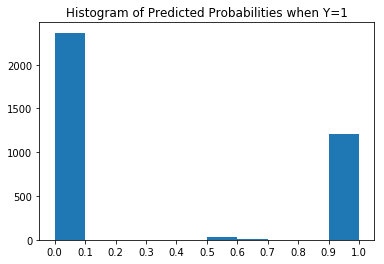

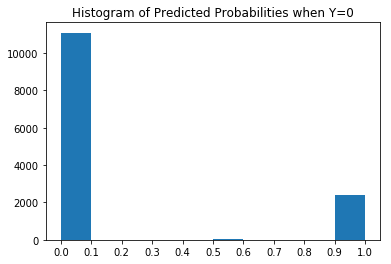

In [156]:
# Plot Histograms of predicted probabilities when Y=1 and Y=1 using validation set
# (unregularized decision tree)
Y_and_Y_hat_dt_unr = f.actual_and_predicted_values(clf_base, \
                        valid_expanded_preprocessed, True, \
                        ['Y', 'Median_household_income'])
f.predicted_proba_histograms_by_Y(Y_and_Y_hat_dt_unr)

In [157]:
# Fit a decision tree of depth 10.
clf_d10 = DecisionTreeClassifier(criterion='entropy', max_depth = 10)
clf_d10 = clf_d10.fit(train_expanded_preprocessed.drop(['Y', 'Median_household_income'], \
         axis=1), train_expanded_preprocessed['Y'])


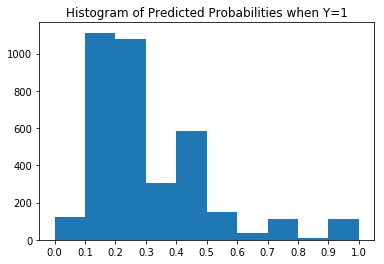

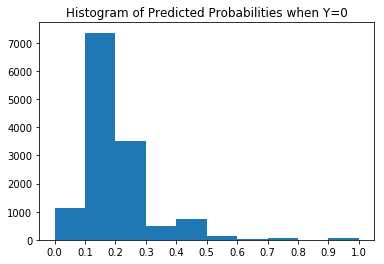

In [160]:
# Plot histograms of predicted probabilities for Y=1 and Y=0 (decision tree of depth 10)
Y_and_Y_hat_dt_d10 = f.actual_and_predicted_values(clf_d10, \
                        valid_expanded_preprocessed, True, \
                        ['Y', 'Median_household_income'])
f.predicted_proba_histograms_by_Y(Y_and_Y_hat_dt_d10)

In [161]:
fpr_and_fnr_results = \
    f.store_fpr_and_fnr_results(clf_base, 'DT unregularized', True, \
    valid_expanded_preprocessed, ['Y', 'Median_household_income'], 0.5, fpr_and_fnr_results)

fpr_and_fnr_results = \
    f.store_fpr_and_fnr_results(clf_d10, 'DT of depth 10', True, \
    valid_expanded_preprocessed, ['Y', 'Median_household_income'], 0.5, fpr_and_fnr_results)
fpr_and_fnr_results

{'base_2_preprocess, threshold of 0.5': {'fpr': '0.021', 'fnr': '0.898'},
 'base_expanded_unr_preprocessed': {'fpr': '0.026', 'fnr': '0.876'},
 'L1_C100_expanded_preprocessed': {'fpr': '0.026', 'fnr': '0.876'},
 'L2_C1_expanded_balanced_w': {'fpr': '0.340', 'fnr': '0.317'},
 'L1_C01_zip_balanced_w': {'fpr': '0.336', 'fnr': '0.318'},
 'DT unregularized': {'fpr': '0.181', 'fnr': '0.655'},
 'DT of depth 10': {'fpr': '0.023', 'fnr': '0.886'}}

Judging by false positive and false negative rates, the unregularized DT tends to favor positive outcomes more than the regularized decision tree of depth 15. 

Overall, decision tree models are performing worse than the majority of logistic regression models tried above. If non-linearities do not play a significant role in predicting outcomes, and linear models are powerful enough to capture signals in data, then the subpar performance of decision trees relative to logistic regressions is not surprising.

In the next IPython Notebook, I peform some additional data analyses and modeling, including taking a closer look at the data points where my logitic models make mistakes and trying models with interaction terms. 

